# Match prediction model training

## Dependencies import

In [1]:
import pandas as pd
import keras
import tensorflow as tf
from keras import layers
from keras_hub.layers import SinePositionEncoding, PositionEmbedding
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import numpy as np
import joblib
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pathlib
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict

2026-02-13 12:46:26.751792: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/euclasio/Documents/footyguess/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utilitary

In [2]:
def build_registries(events):
    num_features = set()
    cat_vocab = defaultdict(set)

    for ev in events:
        num_features.update(ev["numerical"].keys())
        for k, v in ev["categorical"].items():
            cat_vocab[k].add(v)

    num_index = list(num_features)
    cat_index = list(cat_vocab.keys())
    cat_vocab = {
        k: {v: i+1 for i, v in enumerate(sorted(vals))}
        for k, vals in cat_vocab.items()
    }

    return num_index, cat_index, cat_vocab

def flatten_dict(d, prefix=""):
    out = {}

    for k, v in d.items():
        key = f"{prefix}.{k}" if prefix else k

        if isinstance(v, dict):
            out.update(flatten_dict(v, key))

        elif isinstance(v, list):
            for i, element in enumerate(v):
                list_key = f"{key}.{i}"
                if isinstance(element, dict):
                    out.update(flatten_dict(element, list_key))
                elif isinstance(element, bool):
                    out[list_key] = int(element)
                else:
                    out[list_key] = element

        else:
            out[key] = v

    return out

def drop_non_numbers(d):
    filtered = {}
    for k, v in d.items():
        if isinstance(v, (int, float)):
            filtered[k] = v
    return filtered

# Definitions

In [3]:
categorical_keys = set(['id', 'formation'])
skip_keys = set(["related_events", "freeze_frame", 'lineup', 'index', 'replacement', 'period', 'player', 'timestamp', 'minute', 'second', 'off_camera', 'half_start'])
skip_events_id = set([])
directory = pathlib.Path('datasets_statsbomb')

# Build vocabulary

In [4]:
# all_events = []

# for filename in directory.iterdir():
    
#     file = open(filename, 'r')
#     events = json.load(file)
#     file.close()

#     lineup_home = events[0]
#     lineup_away = events[1]
#     locality = {lineup_home['team']['id']: 1,
#                 lineup_away['team']['id']: 2}
    
#     player_positions = {}

#     for event in events:

#         if event['period'] > 1:
#             continue
        
#         if event['type']['id'] in skip_events_id:
#             continue

#         if event['type']['id'] in [35, 36]: ## lineups
#             lineup = event['tactics'].pop('lineup')
#             for player in lineup:
#                 player_positions[player['player']['id']] = player['position']['id']
        
#         flattened = flatten_dict(event)

#         position = flattened.get('position.id', None)
#         if position == 0:
#             flattened['position.id'] = 26 # reserve 0 as MISSING token

#         if 'substitution.replacement.id' in flattened:
#             position = flattened['position.id']
#             player_id = flattened['substitution.replacement.id']
#             player_positions[player_id] = position

#         if 'team.id' in flattened:
#             flattened['team.id'] = locality[flattened['team.id']]

#         if 'possession_team.id' in flattened:
#             flattened['possession_team.id'] = locality[flattened['possession_team.id']]
            
#         if 'pass.recipient.id' in flattened:
#             recipient_id = flattened['pass.recipient.id']
#             flattened['pass.recipient.id'] = player_positions[recipient_id]

#         flattened = drop_non_numbers(flattened)
        
#         numerical = {}
#         categorical = {}
#         for k, v in flattened.items():
#             var_types = set(k.split('.'))
#             if len(skip_keys.intersection(var_types)) > 0:
#                 continue
#             if len(categorical_keys.intersection(var_types)) > 0:
#                 categorical[k] = v
#             else:
#                 numerical[k] = v
        
#         all_events.append({"numerical": numerical, "categorical": categorical})
    
# num_idx, cat_idx, cat_vocab = build_registries(all_events)

# joblib.dump(num_idx, 'num_idx.pkl')
# joblib.dump(cat_idx, 'cat_idx.pkl')
# joblib.dump(cat_vocab, 'cat_vocab.pkl')


# Labels

In [5]:
labels_dir = pathlib.Path('labels')

results_by_id = {}

for folder in labels_dir.iterdir():
    for file in folder.iterdir():
        file = open(file, 'r')
        data = json.load(file)
        file.close()

        for match in data:
            id = match['match_id']
            home_score = match['home_score']
            away_score = match['away_score']
            result = 0
            if home_score < away_score:
                result = 1
            elif home_score == away_score:
                result = 2
            results_by_id[id] = result

## Data preprocessing

In [6]:
num_order = joblib.load('num_idx.pkl')
cat_order = joblib.load('cat_idx.pkl')
cat_vocab = joblib.load('cat_vocab.pkl')

max_T = 1600

home = []
away = []
draw = []

max_event_count = 0
avg_event_count = 0

for filename in directory.iterdir():
    
    file = open(filename, 'r')
    events = json.load(file)
    file.close()

    out = {k: [] for k in cat_order}
    out['numerical'] = []

    label = results_by_id.get(int(filename.stem), None)
    if label is None:
        continue
    out['result'] = label

    lineup_home = events[0]
    lineup_away = events[1]
    locality = {lineup_home['team']['id']: 1,
                lineup_away['team']['id']: 2}
    
    player_positions = {}
    
    count = 0

    for event in events:
        if count == max_T:
            break

        if event['period'] != 1:
            continue

        if event['type']['id'] in skip_events_id:
            continue

        if event['type']['id'] in [35, 36]: ## lineups
            lineup = event['tactics'].pop('lineup')
            for player in lineup:
                player_positions[player['player']['id']] = player['position']['id']
        
        flattened = flatten_dict(event)

        position = flattened.get('position.id', None)
        if position == 0:
            flattened['position.id'] = 26 # reserve 0 as MISSING token

        if 'substitution.replacement.id' in flattened:
            position = flattened['position.id']
            player_id = flattened['substitution.replacement.id']
            player_positions[player_id] = position

        if 'team.id' in flattened:
            flattened['team.id'] = locality[flattened['team.id']]

        if 'possession_team.id' in flattened:
            flattened['possession_team.id'] = locality[flattened['possession_team.id']]
            
        if 'pass.recipient.id' in flattened:
            recipient_id = flattened['pass.recipient.id']
            flattened['pass.recipient.id'] = player_positions[recipient_id]

        flattened = drop_non_numbers(flattened)
        
        numerical = {}
        categorical = {}
        for k, v in flattened.items():
            var_types = set(k.split('.'))
            if len(skip_keys.intersection(var_types)) > 0:
                continue
            if len(categorical_keys.intersection(var_types)) > 0:
                categorical[k] = v
            else:
                numerical[k] = v

        num_vec = []

        for field in num_order:
            value = numerical.get(field, None)
            num_vec.append(value if value is not None else 0.0)           # magnitude
            num_vec.append(1.0 if value is not None else 0.0)  # presence flag

        for field in cat_order:
            raw_val = categorical.get(field, None)
            if raw_val is None:
                out[field].append(0)  # PAD / MISSING token
            else:
                out[field].append(cat_vocab[field].get(raw_val, 0))

        out["numerical"].append(num_vec)
        count += 1

    for k in cat_order:
        out[k] = np.pad(array=np.array(out[k], dtype=np.int32),
                        pad_width=((0, max_T - len(out[k])),),
                        constant_values=0)
    
    current_len = len(out['numerical'])
    out["numerical"] = np.pad(array=np.array(out["numerical"], dtype=np.float32), 
                              pad_width=((0, max_T - current_len), (0, 0)),
                              constant_values=0.0)

    if label == 0:
        home.append(out)
    elif label == 1:
        away.append(out)
    else:
        draw.append(out)

# Stats calculation for performance comparison

In [7]:
def get_halftime_goals(match):
    shots = match.get('shot.outcome.id')
    event_types = match.get('type.id')
    indices = np.concatenate([
        np.where(shots == cat_vocab['shot.outcome.id'][97])[0], # goal scored event
        np.where(event_types == cat_vocab['type.id'][25])[0] # favorable own goal
    ])
    goals_by_team = match.get('team.id')[indices]
    values, counts = np.unique(goals_by_team, return_counts=True)
    return dict(zip(values, counts))


def probability_matrix(matches):
    homeHalf_homeEnd = 0
    drawHalf_homeEnd = 0
    awayHalf_homeEnd = 0

    homeHalf_drawEnd = 0
    drawHalf_drawEnd = 0
    awayHalf_drawEnd = 0

    homeHalf_awayEnd = 0
    drawHalf_awayEnd = 0
    awayHalf_awayEnd = 0

    for match in matches:
        goals = get_halftime_goals(match)
        goals_home = goals.get(1, 0)
        goals_away = goals.get(2, 0)
        fulltime_result = match.get('result')

        if fulltime_result == 0:
            if goals_home > goals_away:
                homeHalf_homeEnd += 1
            elif goals_home < goals_away:
                awayHalf_homeEnd += 1
            else:
                drawHalf_homeEnd += 1
        
        elif fulltime_result == 1:
            if goals_home > goals_away:
                homeHalf_awayEnd += 1
            elif goals_home < goals_away:
                awayHalf_awayEnd += 1
            else:
                drawHalf_awayEnd += 1
        
        elif fulltime_result == 2:
            if goals_home > goals_away:
                homeHalf_drawEnd += 1
            elif goals_home < goals_away:
                awayHalf_drawEnd += 1
            else:
                drawHalf_drawEnd += 1

    ht_home_count = homeHalf_homeEnd + homeHalf_awayEnd + homeHalf_drawEnd
    ht_away_count = awayHalf_homeEnd + awayHalf_awayEnd + awayHalf_drawEnd
    ht_draw_count = drawHalf_homeEnd + drawHalf_awayEnd + drawHalf_drawEnd

    matrix = [
        [homeHalf_homeEnd / ht_home_count, homeHalf_awayEnd / ht_home_count, homeHalf_drawEnd / ht_home_count],  # HT Home
        [awayHalf_homeEnd / ht_away_count, awayHalf_awayEnd / ht_away_count, awayHalf_drawEnd / ht_away_count],  # HT Away
        [drawHalf_homeEnd / ht_draw_count, drawHalf_awayEnd / ht_draw_count, drawHalf_drawEnd / ht_draw_count],  # HT Draw
    ]

    labels_x = ["FT Home", "FT Away", "FT Draw"]
    labels_y = ["HT Home", "HT Away", "HT Draw"]

    print("P(FT result | HT result)\n")
    print(f"{'':10s} " + " ".join(f"{x:>10s}" for x in labels_x))

    for y_label, row in zip(labels_y, matrix):
        print(f"{y_label:10s} " + " ".join(f"{v:10.2f}" for v in row))
            

# Train / val / test split

In [8]:
rng = random.Random(42)

rng.shuffle(home)
rng.shuffle(away)
rng.shuffle(draw)

min_class_original = min(len(home), len(away), len(draw))
test_size = int(min_class_original * 0.2)

X_test = (
    [home.pop() for _ in range(test_size)] +
    [away.pop() for _ in range(test_size)] +
    [draw.pop() for _ in range(test_size)]
)
rng.shuffle(X_test)

print("ALL TEST SAMPLES PROBABILITY\n")
probability_matrix(X_test)

X_test_holds = []
X_test_not_hold = []

for match in X_test:
    ht_goals = get_halftime_goals(match)
    ht_result = 0
    ht_result = 1 if ht_goals.get(2, 0) > ht_goals.get(1, 0) else ht_result
    ht_result = 2 if ht_goals.get(2, 0) == ht_goals.get(1, 0) else ht_result

    if ht_result != match['result']:
        X_test_not_hold.append(match)
    else:
        X_test_holds.append(match)

min_class_remaining = min(len(home), len(away), len(draw))
val_size = int(min_class_remaining * 0.1)

X_val = (
    [home.pop() for _ in range(val_size)] +
    [away.pop() for _ in range(val_size)] +
    [draw.pop() for _ in range(val_size)]
)
rng.shuffle(X_val)

X_train = home + away + draw
rng.shuffle(X_train)

Y_train = np.array([m['result'] for m in X_train])
X_train = [{k: tf.constant(v) for k, v in m.items() if k != 'result'} for m in X_train]

Y_test_holds = np.array([m['result'] for m in X_test_holds])
X_test_holds = [{k: tf.constant(v) for k, v in m.items() if k != 'result'} for m in X_test_holds]

Y_test_no_hold = np.array([m['result'] for m in X_test_not_hold])
X_test_no_hold = [{k: tf.constant(v) for k, v in m.items() if k != 'result'} for m in X_test_not_hold]

Y_val = np.array([m['result'] for m in X_val])
X_val = [{k: tf.constant(v) for k, v in m.items() if k != 'result'} for m in X_val]

ALL TEST SAMPLES PROBABILITY

P(FT result | HT result)

              FT Home    FT Away    FT Draw
HT Home          0.68       0.09       0.23
HT Away          0.05       0.72       0.23
HT Draw          0.28       0.24       0.47


I0000 00:00:1771005291.419663   72098 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6631 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


# Class weighting

In [9]:
classes = np.unique(Y_train)

weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=Y_train
)

class_weights = dict(zip(classes, weights))

# Dataset generator

In [10]:
def train_gen():
    for x, y in zip(X_train, Y_train):
        yield x, y

def val_gen():
    for x, y in zip(X_val, Y_val):
        yield x, y

def batchify(ds):
    return (
        ds
        .padded_batch(
            batch_size=8,
            padded_shapes=(
                {
                    **{k: [None] for k in cat_order},
                    "numerical": [None, len(num_order) * 2],
                },
                []
            ),
            padding_values=(
                {
                    **{k: 0 for k in cat_order},
                    "numerical": 0.0,
                },
                0
            )
        )
        .prefetch(tf.data.AUTOTUNE)
    )


output_signature = (
    {
        **{
            k: tf.TensorSpec(shape=(None,), dtype=tf.int32)
            for k in cat_order
        },
        "numerical": tf.TensorSpec(shape=(None, len(num_order) * 2), dtype=tf.float32),
    },
    tf.TensorSpec(shape=(), dtype=tf.int32),
)

train_ds = (
    tf.data.Dataset.from_generator(train_gen, output_signature=output_signature)
    .apply(tf.data.experimental.assert_cardinality(len(Y_train)))
    .cache()
    .shuffle(buffer_size=len(Y_train))
)

val_ds = (
    tf.data.Dataset.from_generator(val_gen, output_signature=output_signature)
    .apply(tf.data.experimental.assert_cardinality(len(Y_val)))
    .cache()
)

train_ds = batchify(train_ds)
val_ds = batchify(val_ds)

## Model compilation

In [11]:
cat_vocab_sizes = {k: len(v.values()) for k, v in cat_vocab.items()}

def emb_dim(vocab_size):
    return min(8, int(vocab_size ** 0.5) + 1)

emb_dims = {k: emb_dim(v) for k, v in cat_vocab_sizes.items()}

def build_match_model(
        cat_order,
        cat_vocab_sizes,
        emb_dims,
        num_dim,
        num_classes=3,
        model_dim=64,
):
    cat_inputs = {
        k: keras.Input(shape=(None,), dtype="int32", name=k) for k in cat_order
    }
    num_input = keras.Input(
        shape=(None, num_dim),
        dtype="float32",
        name="numerical"
    )

    cat_embs = []
    for k in cat_order:
        x = layers.Embedding(
            input_dim=cat_vocab_sizes[k] + 1,
            output_dim=emb_dims[k],
            name=f"emb_{k}"
        )(cat_inputs[k])
        cat_embs.append(x)

    num_x = layers.Dense(model_dim, name="num_proj")(num_input)

    x = layers.Concatenate(axis=-1)(cat_embs + [num_x])
    x = layers.Dense(128)(x)
    x = layers.ReLU()(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(model_dim)(x)

    # x = PositionEmbedding(sequence_length=max_T)(x) + x

    attn_input = x
    x = layers.MultiHeadAttention(
        num_heads=4,
        key_dim=model_dim // 4,
        dropout=0.1
    )(x, x)

    x = layers.Add()([x, attn_input])
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64)(x)
    x = layers.ReLU()(x)
    
    x = layers.Dense(num_classes)(x)
    output = x = layers.Softmax()(x)

    return keras.Model(
        inputs={**cat_inputs, "numerical": num_input},
        outputs=output
    )

model = build_match_model(
    cat_order=cat_order,
    num_dim=len(num_order) * 2,
    cat_vocab_sizes=cat_vocab_sizes,
    emb_dims=emb_dims
)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy'])  

## Training callbacks

In [12]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-5
)


## Model fitting

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[early_stop, lr_callback],
    class_weight=class_weights
)

Epoch 1/1000


KeyboardInterrupt: 

# Save and visualization

In [ ]:
model.save('statsbomb.keras')

loss = history.history['loss']
val_loss = history.history.get('val_loss')  # safe if no validation

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, label='Training Loss')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

## Testing and model evaluation

2026-02-13 12:55:17.951616: I external/local_xla/xla/service/service.cc:163] XLA service 0x7c6168008240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-13 12:55:17.951630: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2026-02-13 12:55:18.008064: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-13 12:55:18.078503: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91900


 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

I0000 00:00:1771005319.737767   76642 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
              precision    recall  f1-score   support

        HOME       0.88      0.82      0.85        95
        AWAY       0.83      0.87      0.85        98
        DRAW       0.70      0.72      0.71        95

    accuracy                           0.80       288
   macro avg       0.80      0.80      0.80       288
weighted avg       0.80      0.80      0.80       288



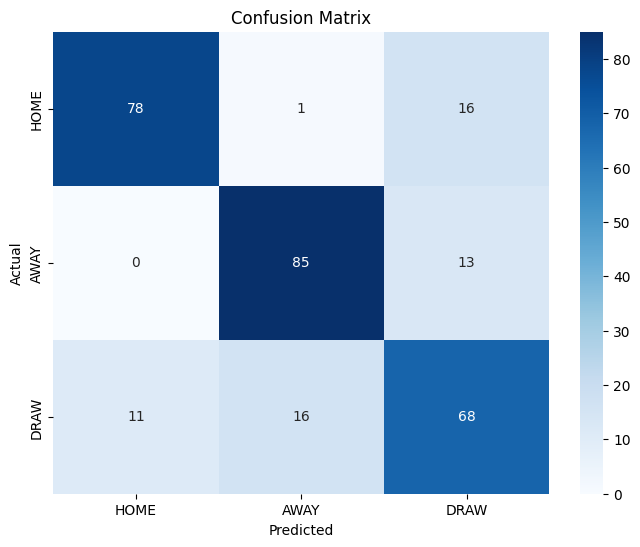

In [14]:
model = keras.models.load_model('statsbomb.keras')

def gen_test_holds():
    for x, y in zip(X_test_holds, Y_test_holds):
        yield x, y

test_ds = tf.data.Dataset.from_generator(
    gen_test_holds,
    output_signature=output_signature
)

test_ds = test_ds.apply(
    tf.data.experimental.assert_cardinality(len(Y_test_holds))
)

test_ds = batchify(test_ds)


labels = ['HOME', 'AWAY', 'DRAW']
Y_pred_probs = model.predict(test_ds)
Y_pred = np.argmax(Y_pred_probs, axis=1)

Y_pred_strings = [labels[i] for i in Y_pred]
Y_true_strings = [labels[i] for i in Y_test_holds]

cm = confusion_matrix(Y_true_strings, Y_pred_strings, labels=labels)
print(classification_report(
    Y_test_holds,
    Y_pred,
    labels=[0,1,2],
    target_names=labels
))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step
              precision    recall  f1-score   support

        HOME       0.34      0.22      0.27        64
        AWAY       0.33      0.30      0.31        61
        DRAW       0.18      0.27      0.22        64

    accuracy                           0.26       189
   macro avg       0.29      0.26      0.26       189
weighted avg       0.28      0.26      0.26       189



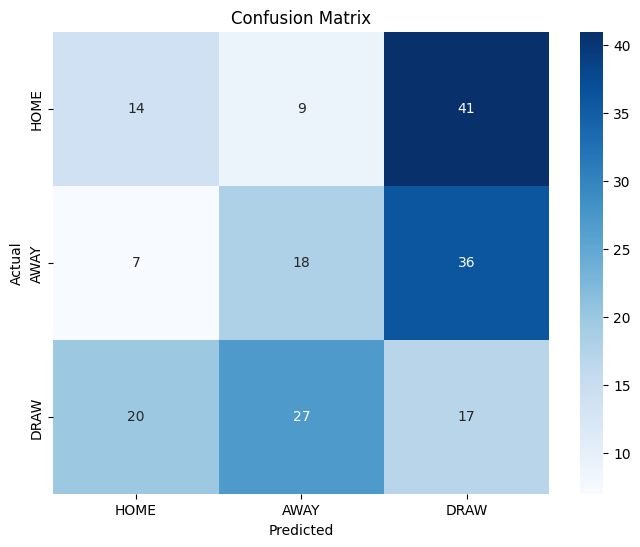

In [15]:
model = keras.models.load_model('statsbomb.keras')

def gen_test_no_hold():
    for x, y in zip(X_test_no_hold, Y_test_no_hold):
        yield x, y

test_ds = tf.data.Dataset.from_generator(
    gen_test_no_hold,
    output_signature=output_signature
)

test_ds = test_ds.apply(
    tf.data.experimental.assert_cardinality(len(Y_test_no_hold))
)

test_ds = batchify(test_ds)


labels = ['HOME', 'AWAY', 'DRAW']
Y_pred_probs = model.predict(test_ds)
Y_pred = np.argmax(Y_pred_probs, axis=1)

Y_pred_strings = [labels[i] for i in Y_pred]
Y_true_strings = [labels[i] for i in Y_test_no_hold]

cm = confusion_matrix(Y_true_strings, Y_pred_strings, labels=labels)
print(classification_report(
    Y_test_no_hold,
    Y_pred,
    labels=[0,1,2],
    target_names=labels
))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()